# 6 month data analysis


In [1]:
import pandas as pd;
import plotly.graph_objects as go;
import plotly.express as px;
import datetime;


## Importing data from Baby Buddy


Import all .csv data sets exported from the [Baby Buddy](https://github.com/babybuddy/babybuddy) app:


In [2]:
df_sleep = pd.read_csv('data/sleep.csv');
df_feeding = pd.read_csv('data/feeding.csv');
df_diaper = pd.read_csv('data/diaper.csv');
df_weight = pd.read_csv('data/weight.csv');

Transform all date string to Date type:


In [3]:
df_sleep['start'] = pd.to_datetime(df_sleep['start'], format='%d/%m/%Y %H:%M');
df_sleep['end'] = pd.to_datetime(df_sleep['end'], format='%d/%m/%Y %H:%M');
df_feeding['start'] = pd.to_datetime(df_feeding['start'], format='%d/%m/%Y %H:%M');
df_feeding['end'] = pd.to_datetime(df_feeding['end'], format='%d/%m/%Y %H:%M');
df_diaper['time'] = pd.to_datetime(df_diaper['time'], format='%d/%m/%Y %H:%M');
df_weight['date'] = pd.to_datetime(df_weight['date'], format='%d/%m/%Y');

Remove any data points more recent than the 6 month mark:


In [4]:
df_sleep.drop(df_sleep[df_sleep.start > '2024-02-15'].index, inplace=True);
df_feeding.drop(df_feeding[df_feeding.start > '2024-02-15'].index, inplace=True);
df_diaper.drop(df_diaper[df_diaper.time > '2024-02-15'].index, inplace=True);
df_weight.drop(df_weight[df_weight.date > '2024-02-15'].index, inplace=True);

Add duration columns:


In [5]:
df_sleep['duration'] = df_sleep['end'] - df_sleep['start'];
df_feeding['duration'] = df_feeding['end'] - df_feeding['start'];

## Time Analysis


Total time of 6 months since baby was born is 184 days. Unfortunately we only have sleep data since the 5th of September, which is 163 days:


In [6]:
total_time = pd.to_timedelta(24*7, 'h');
time_asleep = df_sleep[['start','duration']].groupby(pd.Grouper(key='start', freq='1W')).sum().reset_index();
time_asleep['awake'] = total_time - time_asleep['duration'];

time_feeding = df_feeding[['start','duration']].groupby(pd.Grouper(key='start', freq='1W')).sum().reset_index();
time_feeding['partying'] = time_asleep['awake'] - time_feeding['duration'];

In [7]:
time_asleep = time_asleep[1:-1];
time_feeding = time_feeding[1:-1];

In [8]:
def createFrame(week):
    total_hours = 24*7;
    asleep_hours = time_asleep.loc[week]['duration'].total_seconds()//3600;
    awake_hours = time_asleep.loc[week]['awake'].total_seconds()//3600;
    feeding_hours = time_feeding.loc[week]['duration'].total_seconds()//3600;
    partying_hours = time_feeding.loc[week]['partying'].total_seconds()//3600;

    pct_asleep = f"{asleep_hours / total_hours:.0%}";
    pct_awake = f"{awake_hours / total_hours:.0%}";
    pct_feeding = f"{feeding_hours / total_hours:.0%}";
    pct_partying = f"{partying_hours / total_hours:.0%}";


    return {"data": [go.Sankey(
    arrangement='snap',
    # Define nodes
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label =  [
          f'Total Time', 
          f'Asleep ({pct_asleep})', 
          f'Awake ({pct_awake})', 
          f'Feeding ({pct_feeding})', 
          f'Partying ({pct_partying})'],
      x= [0, 0.5, 0.5, 1, 1],
      y = [0.2, 0.2, 0.5, 0.5, 0.5],
      align = 'left'
    ),
    # Add links
    link = dict(
      source =  [0, 0, 2, 2],
      target =  [1, 2, 3, 4],
      value =  [
          asleep_hours,
          awake_hours, 
          feeding_hours, 
          partying_hours
        ]
))],
"name": str(week),
"layout": go.Layout(
  title=f'Baby\'s time management (Week {week}) 🕥')}

In [9]:
frames = [];
slider_steps = [];
for week in range(1,len(time_asleep)):
    frames.append(go.Frame(createFrame(week)))
    slider_steps.append({
        "args": [
        [week],
        {"frame": {"duration": 300, "redraw": True},
         "mode": "immediate",
         "transition": {"duration": 300}}
    ],
        "label": week,
        "method": "animate"
    })

In [10]:
fig = go.Figure(data=createFrame(1)['data'],
layout=go.Layout(
  title=f'Baby\'s time management (Week 1) 🕥',
  updatemenus=[dict(
            type="buttons",
            buttons=[dict(label="▶",
                          method="animate",
                          args=[None, {"frame": {"duration": 600, "redraw": True},
                                "fromcurrent": True, "transition": {"duration": 0,
                                                                    "easing": "quadratic-in-out"}}]),
                    dict(label="⏸",
                          method="animate",
                          args=[[None], {"frame": {"duration": 0, "redraw": False},
                                "mode": "immediate", "transition": {"duration": 0}}])],
            direction= "left",
        pad= {"r": 10, "t": 87},
        showactive= False,
        x= 0.08,
        xanchor="right",
        y= 0.3,
        yanchor= "top")],
  sliders=[dict(
      active=0,
      yanchor='top',
      xanchor='left',
      x= 0,
      y= 0,
      currentvalue= {
        "font": {"size": 14},
        "prefix": "Week:",
        "visible": True,
        "xanchor": "right"
    },
      transition= {"duration": 300, "easing": "cubic-in-out"},
      pad= {"b": 10, "t": 50},
      len= 0.9,
      steps = slider_steps
  )]
),
frames=frames
)
fig.show()

In [11]:
df_feeding_hours = pd.DataFrame({ 'week': range(0, 26, 1)});
df_feeding_hours['feeding'] = (df_feeding[['duration','start']].groupby(pd.Grouper(key='start', freq='1W')).sum().reset_index())['duration'].map(lambda x: x.total_seconds()/3600);

df_feeding_hours = df_feeding_hours.tail(-1);
df_feeding_hours['Date'] = df_feeding_hours['week'].apply(lambda x: pd.to_datetime('2023-08-15', format='%Y-%m-%d') + pd.Timedelta(f"{(x-1)*7}D"))

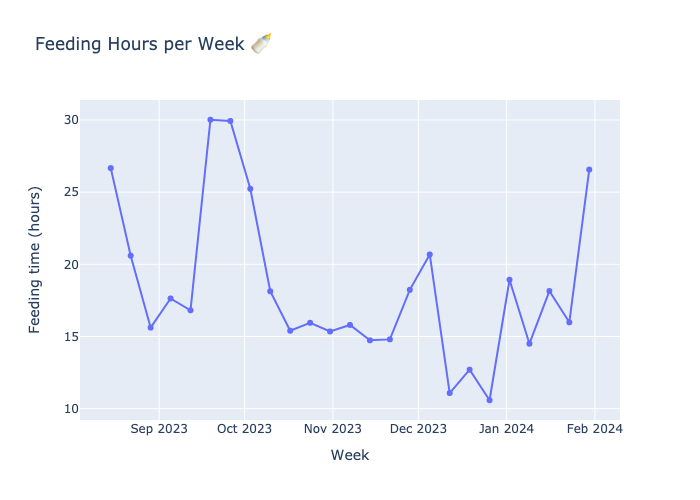

In [12]:
fig = px.line(df_feeding_hours, x='Date', y='feeding', markers=True, title='Feeding Hours per Week 🍼');
fig.update_layout(xaxis_title='Week',
                   yaxis_title='Feeding time (hours)');
fig.show('png');

## Diaper analysis


Sum the number of solid diapers per day and then calculate the average per week:


In [13]:
df_poops_per_day = df_diaper[['solid', 'time']].groupby(pd.Grouper(key='time', freq='1D')).sum().reset_index()
df_poops_per_week_avg = df_poops_per_day.groupby(pd.Grouper(key='time', freq='7D')).mean().reset_index()

In [14]:
df_poops_per_week_avg.head()

,time,solid
0,2023-08-15,3.857143
1,2023-08-22,5.714286
2,2023-08-29,2.571429
3,2023-09-05,0.857143
4,2023-09-12,1.428571


Plot the data on a bar chart:


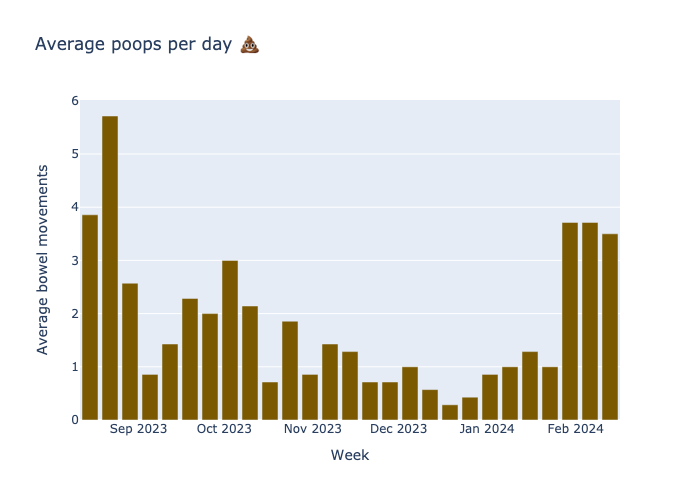

In [15]:
x = df_poops_per_week_avg['time']
y = df_poops_per_week_avg['solid']

fig = go.Figure()
fig.add_trace(go.Bar(
                    y=y,
                    x=x,
              marker_color='#7A5901'
))
fig.update_layout(bargap=0.2, title_text='Average poops per day 💩', yaxis_title='Average bowel movements',
                   xaxis_title='Week')
fig.show('png')

## Sleep Analysis

In [16]:
def weekTimeToDate(week: int, day: int, time: datetime.time):
    startDate = pd.to_datetime('2023-09-06', format='%Y-%m-%d');
    return startDate + pd.Timedelta(f'{(week-1)*7 + day}D') + pd.Timedelta(time);

In [17]:
def is_asleep(week: int, day: int, time: str):
    intervalStartTime = weekTimeToDate(week, day, time);
    intervalEndTime = weekTimeToDate(week, day, pd.Timedelta(time) + pd.Timedelta('00:29:59'));

    for index, row in df_sleep.iterrows():
        # If the start of the interval is during the sleep window, we count it
        if (row['start'] <= intervalStartTime) and (row['end'] >= intervalStartTime):
            return 1;
        # If the end of the interval is during the sleep window, we count it
        if (row['start'] <= intervalEndTime) and (row['end'] >= intervalEndTime):
            return 1;
        # If the nap is completely contained within an interval window, we still count it
        if (intervalStartTime >= row['start']) and (intervalEndTime <= row['end']):
            return 1;
    return 0;

In [18]:
rows = [];

for week in range(1, 22, 1):
    for day in range(0, 7, 1):
        for timestamp in pd.date_range("00:00", "23:30", freq="30min").time:
            rows.append([week, timestamp, is_asleep(week, day, timestamp.strftime('%H:%M:%S'))]);

df_sleep_times = pd.DataFrame(rows, columns=['Week', 'Time', 'Asleep']);

In [19]:
df_sleep_times['Date'] = df_sleep_times['Week'].apply(lambda x: pd.to_datetime('2023-09-05', format='%Y-%m-%d') + pd.Timedelta(f"{(x-1)*7}D"))

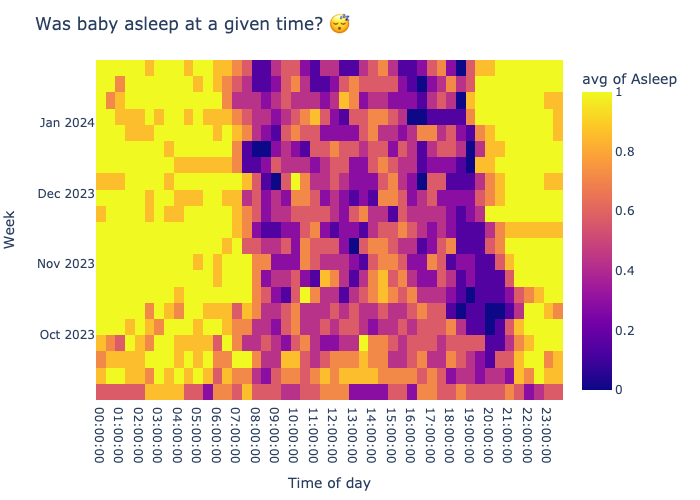

In [20]:
fig = px.density_heatmap(df_sleep_times, x="Time", y="Date", z="Asleep", histfunc="avg", nbinsy=21);
fig.update_layout(title_text='Was baby asleep at a given time? 😴', yaxis_title='Week',
                   xaxis_title='Time of day')
fig.show('png')